<center>
  <h2>Trabajo Laboratorio de Implementación III - MCD Virtual Cohorte 2022</h2>
  <h3>Forecasting para una Empresa de Consumo Masivo</h3>
  <h4>Experimento 8 AutoGluon</h4>
</center>

In [2]:
# !pip install autogluon
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")
from autogluon.timeseries import TimeSeriesDataFrame, TimeSeriesPredictor

In [3]:
# !pip uninstall torch
# !pip install torch
# Si se obtiene NameError: name '_C' is not defined al entrenar predictor

In [4]:
df_ventas_product = pd.read_csv("C:/Users/usuario/otros/Desktop/MCD/6 Labo III/Forecasting Problem/Datasets/df_ventas_product.csv", header = None)
df_ventas_product.columns = ["periodo", "product_id", "tn"]
df_ventas_product.head(5)

,periodo,product_id,tn
0,2017-01-01,20001,934.77222
1,2017-01-01,20002,550.15707
2,2017-01-01,20003,1063.45835
3,2017-01-01,20004,555.91614
4,2017-01-01,20005,494.27011


In [5]:
# Función para estandarizar una serie de tiempo
def standardize_series(series):
    mean = series.mean()
    std = series.std()
    standardized_series = (series - mean) / std
    return standardized_series, mean, std

# Función para revertir la estandarización de una serie de tiempo
def reverse_standardization(standardized_series, mean, std):
    reversed_series = standardized_series * std + mean
    return reversed_series

# Estandarizar todas las series de tiempo por product_id
standardized_data = pd.DataFrame()
means = {}
stds = {}
for product_id, group in df_ventas_product.groupby('product_id'):
    series = group['tn']
    standardized_series, mean, std = standardize_series(series)
    
    standardized_data = pd.concat([standardized_data, pd.DataFrame({'periodo': group['periodo'], 'product_id': product_id, 'tn_standardized': standardized_series})])
    
    means[product_id] = mean
    stds[product_id] = std

standardized_data.head(5)

,periodo,product_id,tn_standardized
0,2017-01-01,20001,-1.554852
496,2017-02-01,20001,-2.013541
994,2017-03-01,20001,-0.318592
1495,2017-04-01,20001,-1.101419
1995,2017-05-01,20001,0.348343


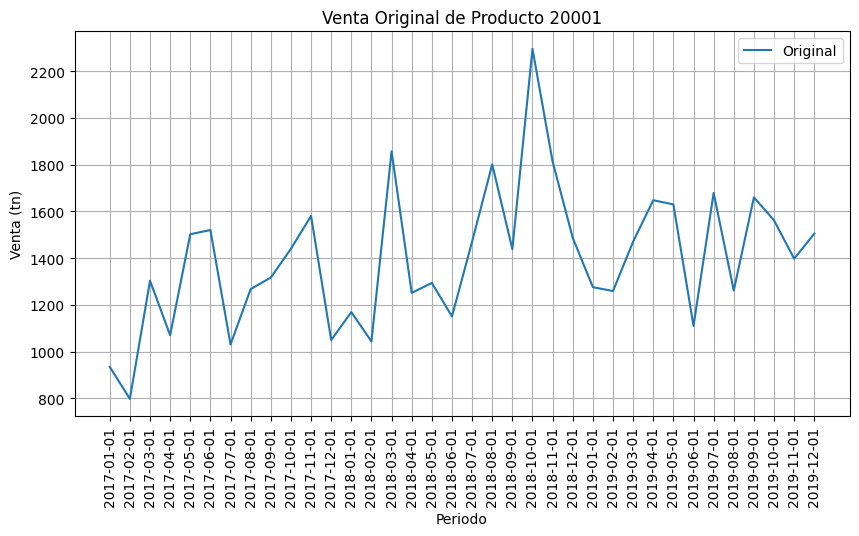

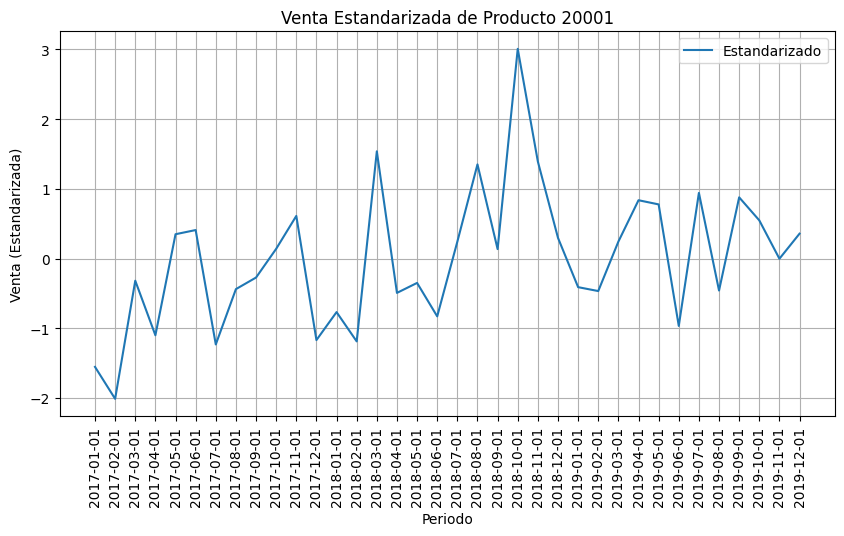

In [6]:
# Seleccionar un producto específico para visualizar
product_id = 20001

# Filtrar los datos para ese producto
df_product = df_ventas_product[df_ventas_product['product_id'] == product_id]

standardized_product = standardized_data[standardized_data['product_id'] == product_id]

# Graficar 'tn' de df_ventas_product
plt.figure(figsize=(10, 5))
plt.plot(df_product['periodo'], df_product['tn'], label='Original')
plt.xlabel('Periodo')
plt.ylabel('Venta (tn)')
plt.title(f'Venta Original de Producto {product_id}')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

# Graficar 'tn_standardized' de standardized_data
plt.figure(figsize=(10, 5))
plt.plot(standardized_product['periodo'], standardized_product['tn_standardized'], label='Estandarizado')
plt.xlabel('Periodo')
plt.ylabel('Venta (Estandarizada)')
plt.title(f'Venta Estandarizada de Producto {product_id}')
plt.legend()
plt.xticks(rotation=90)
plt.grid(True)
plt.show()

In [7]:
# Convertir 'means' y 'stds' en un DataFrame
mean_std_df = pd.DataFrame({'product_id': list(means.keys()),
                            'mean': list(means.values()),
                            'std': list(stds.values())})
mean_std_df.head(1)

,product_id,mean,std
0,20001,1398.344322,298.14546


In [8]:
df = standardized_data.copy()
df = df.rename(columns = {"periodo":"timestamp",
                          "product_id":"item_id",
                          "tn_standardized":"target"})
df = df.reset_index(drop=True)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df['item_id'] = df['item_id'].astype(int)
df['target'] = df['target'].astype(float)
df.head(5)

,timestamp,item_id,target
0,2017-01-01,20001,-1.554852
1,2017-02-01,20001,-2.013541
2,2017-03-01,20001,-0.318592
3,2017-04-01,20001,-1.101419
4,2017-05-01,20001,0.348343


In [9]:
len(df.item_id.unique())

780

In [10]:
data = TimeSeriesDataFrame.from_data_frame(df,
                                           id_column="item_id",
                                           timestamp_column="timestamp")
data

target
item_id timestamp           
20001   2017-01-01 -1.554852
        2017-02-01 -2.013541
        2017-03-01 -0.318592
        2017-04-01 -1.101419
        2017-05-01  0.348343
...                      ...
21276   2019-08-01 -0.751911
        2019-09-01 -0.616417
        2019-10-01 -0.565291
        2019-11-01 -0.275963
        2019-12-01 -0.837426

[22349 rows x 1 columns]

In [11]:
predictor = TimeSeriesPredictor(target='target', prediction_length=2, freq="M").fit(data)

Frequency 'M' stored as 'ME'
Beginning AutoGluon training...
AutoGluon will save models to 'AutogluonModels\ag-20240621_154602'
=================== System Info ===================
AutoGluon Version:  1.1.1
Python Version:     3.11.2
Operating System:   Windows
Platform Machine:   AMD64
Platform Version:   10.0.19045
CPU Count:          8
GPU Count:          0
Memory Avail:       0.67 GB / 7.88 GB (8.5%)
Disk Space Avail:   6.44 GB / 110.21 GB (5.8%)
	We recommend a minimum available disk space of 10 GB, and large datasets may require more.

Fitting with arguments:
{'enable_ensemble': True,
 'eval_metric': WQL,
 'freq': 'ME',
 'hyperparameters': 'default',
 'known_covariates_names': [],
 'num_val_windows': 1,
 'prediction_length': 2,
 'quantile_levels': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
 'random_seed': 123,
 'refit_every_n_windows': 1,
 'refit_full': False,
 'skip_model_selection': False,
 'target': 'target',
 'verbosity': 2}

train_data with frequency 'None' has been resam

In [12]:
predictor.leaderboard()

,model,score_val,pred_time_val,fit_time_marginal,fit_order
0,WeightedEnsemble,-0.498665,94.873313,3.102148,12
1,TemporalFusionTransformer,-0.505683,1.280128,577.939634,9
2,DeepAR,-0.527313,1.777841,117.079428,10
3,PatchTST,-0.611001,1.240945,152.396157,11
4,DynamicOptimizedTheta,-0.627108,46.729221,0.070340,6
5,AutoETS,-0.641735,43.037132,0.078866,7
6,DirectTabular,-0.673101,0.154712,6.616792,3
7,RecursiveTabular,-0.683207,2.153920,41.773175,2
8,AutoARIMA,-0.725660,89.661424,0.063104,8
9,SeasonalNaive,-0.764512,7.848312,0.032206,1


In [14]:
predictor.evaluate(data)

data with frequency 'None' has been resampled to frequency 'ME'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


{'WQL': -0.5134043317767569}

In [15]:
predictions = predictor.predict(data)

data with frequency 'None' has been resampled to frequency 'ME'.
Model not specified in predict, will default to the model with the best validation score: WeightedEnsemble


In [24]:
predictions_v1 = predictions.copy()
predictions_v1 = predictions_v1.reset_index()
predictions_v1 = predictions_v1[["item_id", "timestamp", "mean"]].rename(columns = {"mean":"tn"})
df_merged = pd.merge(predictions_v1, mean_std_df.rename(columns = {"product_id":"item_id"}), on='item_id')
def reverse_standardization(standardized_series, mean, std):
    return standardized_series * std + mean
df_merged['tn_original'] = reverse_standardization(df_merged['tn'], df_merged['mean'], df_merged['std'])
df_original = df_merged[['item_id', 'timestamp', 'tn_original']]
df_original.head(5)

,item_id,timestamp,tn_original
0,20001,2020-01-31,1292.777362
1,20001,2020-02-29,1334.984165
2,20002,2020-01-31,992.904296
3,20002,2020-02-29,1009.285916
4,20003,2020-01-31,790.992818


In [25]:
predictions_v2 = df_original[df_original.timestamp == "2020-02-29"]
predictions_v2 = predictions_v2.drop(columns = {"timestamp"})
predictions_v2 = predictions_v2.rename(columns = {"item_id":"product_id", "tn_original":"tn"})
predictions_v2.head(5)

,product_id,tn
1,20001,1334.984165
3,20002,1009.285916
5,20003,803.638146
7,20004,579.688919
9,20005,544.324836


In [26]:
predictions_v2.to_csv("C:/Users/usuario/otros/Desktop\MCD/6 Labo III/Forecasting Problem/Outputs/prediccion_autogluon_estandarizacion.csv", sep = ",", index = False)